In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from torchmetrics.functional.classification import binary_accuracy
from pathlib import Path

import os

seed_everything(0)

0

In [2]:
class DoomACLitDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, image_size=224, seed=0):
        super().__init__()
        self.batch_size = batch_size
        self.image_size = image_size
        self.seed = seed
    
    def prepare_data(self):
        pass
    
    def setup(self, stage):
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet values, as our CNN was pretrained on Imagenet
        ])
        
        # Animal crossing = 0, Doom = 1
        dataset = torchvision.datasets.ImageFolder("../input/doom-crossing", transform=transform)
        self.full_dataset = dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, (0.7, 0.15, 0.15), generator=torch.Generator().manual_seed(self.seed))
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)
      

In [3]:
def display_image(tensor):
    # Pytorch image format is channels-first, this changes it to channels-last (idx 0 at last position)
    arr = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = arr * std + mean # Undo the Imagenet normalization
    plt.imshow(arr)

In [4]:
# our cnn
class LitResnet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Freeze parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Change last layer
        fc_in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=fc_in_features, out_features=1)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(dim=1) # Convert [batch_size, 1] to [batch_size]
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        self.log("train_loss", loss)
        
        return loss
    
    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(dim=1) # Convert [batch_size, 1] to [batch_size]
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        
        probs = torch.sigmoid(logits) # Convert logits to probabilities
        acc = binary_accuracy(probs, y, threshold=0.5)
        alt_acc = ((logits > 0.0) == y).float().mean()
        
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_alt_acc", alt_acc, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
    
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")
    
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=5e-4,
        )
        
        return optimizer

In [5]:
# Training the model
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)

trainer = pl.Trainer(
    default_root_dir="/kaggle/working",
    accelerator="gpu",
    devices=1,
    max_epochs=50,
    log_every_n_steps=10,
    callbacks=[
        ModelCheckpoint(
            save_weights_only=True,
            mode="max",
            monitor="val_acc",
            dirpath="/kaggle/working/checkpoints",
            filename="{epoch}-{val_loss:.2f}-{val_acc:.2f}"
        ),
        EarlyStopping(
            monitor="val_acc",
            mode="max",
            patience=5,
            verbose=False
        )
    ],
)

dm = DoomACLitDataModule(batch_size=64, image_size=224, seed=0)

checkpoints = list(Path("/kaggle/working/checkpoints").glob("*.ckpt"))
if checkpoints:
    print("Loading model from checkpoint")
    checkpoint = max(checkpoints, key=lambda c: c.stat().st_ctime) # Grab the most recent checkpoint
    model = LitResnet.load_from_checkpoint(str(checkpoint.resolve()))
else:
    print("Training...")
    model = LitResnet(lr=1e-3)
    trainer.fit(model, datamodule=dm)
    # Load best checkpoint after training
    model = LitResnet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Training...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
trainer.validate(model, datamodule=dm)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8791666626930237     │
│        val_alt_acc        │    0.8791666626930237     │
│         val_loss          │    0.3066057860851288     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3066057860851288,
  'val_alt_acc': 0.8791666626930237,
  'val_acc': 0.8791666626930237}]

In [7]:
trainer.test(model, datamodule=dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8619247078895569     │
│       test_alt_acc        │    0.8619247078895569     │
│         test_loss         │     0.362354040145874     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.362354040145874,
  'test_alt_acc': 0.8619247078895569,
  'test_acc': 0.8619247078895569}]

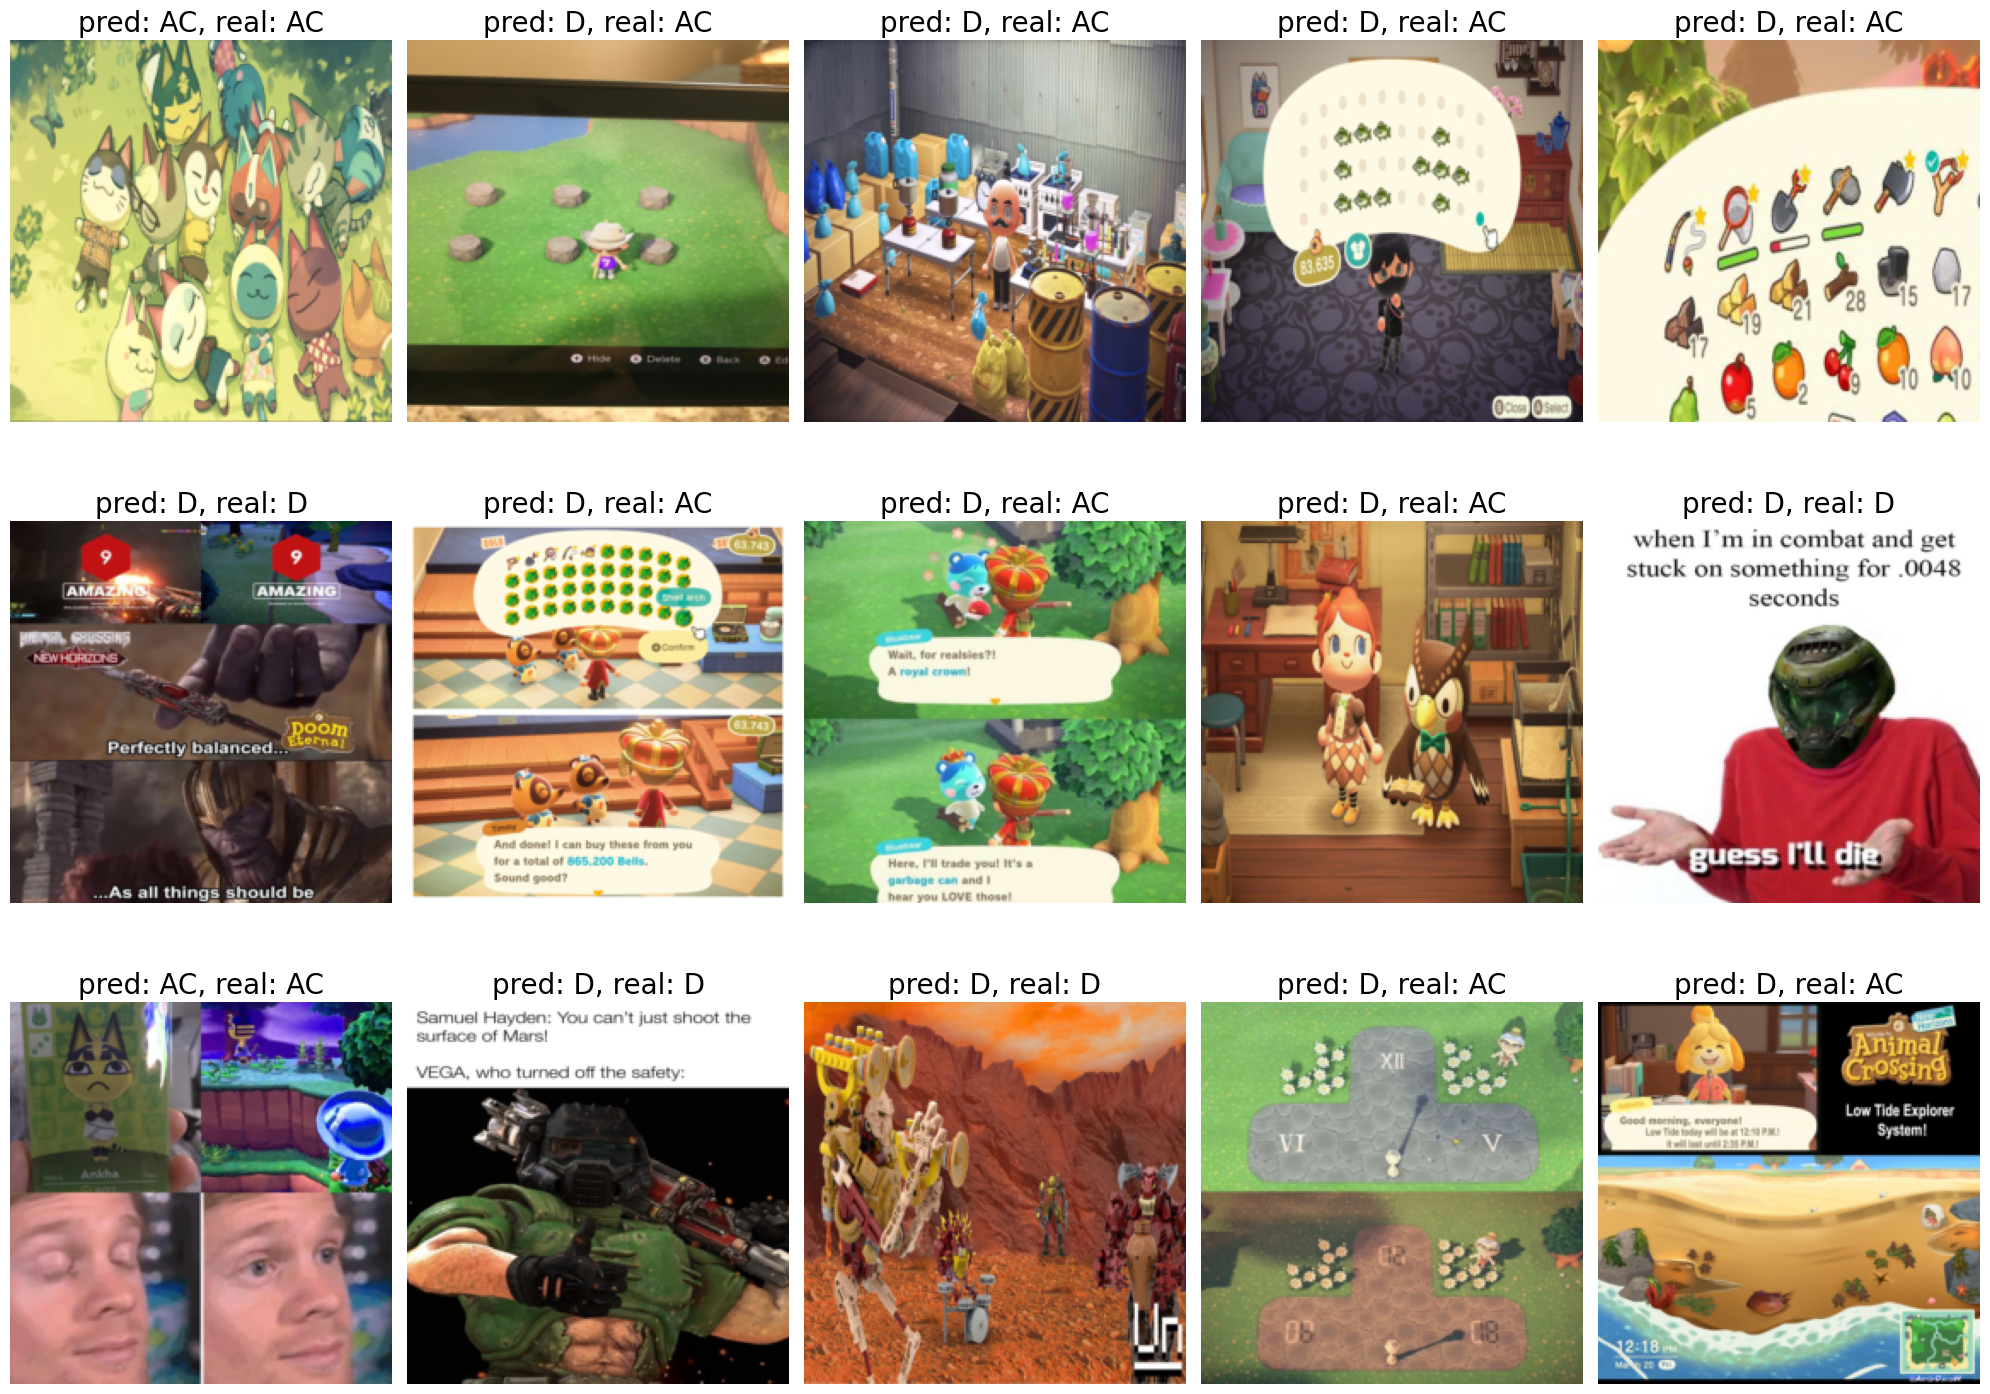

In [8]:
class_names = {
    0: "AC",
    1: "D"
}

def display_image(tensor, ax):
    # Pytorch image format is channels-first, this changes it to channels-last (idx 0 at last position)
    arr = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = arr * std + mean # Undo the Imagenet normalization
    ax.imshow(arr)


def visualize_predictions(model, dataloader, num_images=6):
    fig = plt.figure(figsize=(20,15))
    plotted_images = 0
    
    for inputs, labels in dataloader:
        logits = model(inputs)
        logits = logits.squeeze(dim=1)
        probs = ((logits > 0.0) == labels).int().tolist()
        
        for i in range(inputs.size()[0]):
            plotted_images += 1
            ax = plt.subplot(- (-num_images // 5), 5, plotted_images)
            ax.axis("off")
            ax.set_title(f"pred: {class_names[probs[i]]}, real: {class_names[labels.tolist()[i]]}", fontsize=20)
            display_image(inputs[i], ax)
                         
            if plotted_images >= num_images:
                fig.tight_layout()
                fig.show()
                
                return

visualize_predictions(model, dm.test_dataloader(), num_images=15)

In [9]:
#dataset = torchvision.datasets.ImageFolder("../input/doom-crossing", transform=transform)
#dl = DataLoader(self.train_dataset, batch_size=self.batch_size)